## Computational Physics 2 (WS23/24) – Project 1.2

Group: Emmy Noether

Students: Janik Rausch (628334), Camilo Tello Breuer (633291), Ida Wöstheinreich (628428)

In [1]:
using LinearAlgebra,Random,Printf

**Hamiltonian Module**

...

Periodic boundary conditions: $$\hat{\psi}\big((N_L-1)\textbf{e}_k\big)=\hat{\psi}(N_R\textbf{e}_k)\quad\text{and}\quad\hat{\psi}\big((N_R+1)\textbf{e}_k\big)=\hat{\psi}(N_L\textbf{e}_k)$$ for all $k\in\{1,\ldots,D\}$ with $N_L=-(N-1)/2$ and $N_R=(N-1)/2$ if $N$ is odd

In [2]:
function lattice(N::Int, D::Int) #construct array of lattice coordinates (with n = 0 in the center)
    @assert(N > 0, "N = " * string(N) * " must be positive")
    @assert(D > 0, "D = " * string(D) * " must be positive")
    
    if mod(N,2) == 0 n_1D = -(N-2)/2:N/2 end
    if mod(N,2) == 1 n_1D = -(N-1)/2:(N-1)/2 end

    if D == 1 return collect(n_1D) end
    
    n = collect(Base.product([n_1D for i in 1:D]...)) #Cartesian product
    
    return n
end

function potential(μ::Number, ϵ::Number, n::Array)
    @assert(μ > 0, "μ = " * string(μ) * " must be positive")
    @assert(ϵ > 0, "ϵ = " * string(ϵ) * " must be positive")
    
    return @. μ/8 * (ϵ^2*dot(n,n) - 1)^2
end

function kinetic(μ::Number, ϵ::Number, ψ::Array) #with periodic boundary conditions
    @assert(μ > 0, "μ = " * string(μ) * " must be positive")
    @assert(ϵ > 0, "ϵ = " * string(ϵ) * " must be positive")
    
    D = ndims(ψ)
    N = size(ψ)[1]

    Δ = -2*D*ψ #last term of discretized Laplacian

    for k in 1:D
        Δ += selectdim(ψ, k, vcat(2:N,1:1)) + selectdim(ψ, k, vcat(N:N,1:N-1)) #remaining terms
    end
    
    return -1/(2*μ*ϵ^2) * Δ
end

function Hamiltonian(μ::Number, ϵ::Number, ψ::Array, n::Array) #it would likely be more memory-efficient to pre-calculate the potential
    
    return kinetic(μ, ϵ, ψ) + potential(μ, ϵ, n) .* ψ
end

Hamiltonian (generic function with 1 method)

**Eigenvector Module**

...

In [3]:
function power_method(vshape::Tuple{Vararg{Int}}, apply_A::Function, tol::Float64, maxiters::Int)
    @assert(tol > 0, "tol = " * string(tol) * " must be positive")
    @assert(maxiters > 0, "maxiters = " * string(maxiters) * " must be positive")
    
    v = rand(ComplexF64, vshape)
    niters = 0
    λ = 0
    
    while niters < maxiters
        w = apply_A(v)
        λ = norm(w)
        if max(abs.(w - λ*v)...) < tol break end
        v = w/λ
        niters += 1
    end
    
    if niters == maxiters error("Maximum number of power method iterations reached") end
    
    return λ, v, niters
end

function conjugate_gradient(apply_A::Function, b::Array, tol::Float64, maxiters::Int)
    @assert(tol > 0, "tol = " * string(tol) * " must be positive")
    @assert(maxiters > 0, "maxiters = " * string(maxiters) * " must be positive")
    
    x = rand(ComplexF64, size(b))
    r = b - apply_A(x); p = r
    niters = 0
    
    while niters < maxiters
        x = x + dot(r,r) / dot(p,apply_A(p)) * p
        r_new = b - apply_A(x)
        if norm(r_new) < tol*norm(b) break end
        p = r_new + dot(r_new,r_new) / dot(r,r) * p
        r = r_new
        niters += 1
    end
    
    if niters == maxiters error("Maximum number of conjugate gradient iterations reached") end
    
    return x, niters
end

function lowest_eigenvalue(vshape::Tuple{Vararg{Int}}, apply_A::Function, tol_pm::Float64, maxiters_pm::Int, tol_cg::Float64, maxiters_cg::Int)
    
    function apply_A_inverse(v)
        x, _ = conjugate_gradient(apply_A, v, tol_cg, maxiters_cg)
        return x
    end
    
    λ, v, _ = power_method(vshape, apply_A_inverse, tol_pm, maxiters_pm)
    
    return 1/λ, v
end

lowest_eigenvalue (generic function with 1 method)

**Observable Module**

...

Momentum operator on the lattice:

$$\textbf{p}_a\psi(\textbf{x})=-\frac{i\hbar}{2a}\sum_k\big(\psi(\textbf{x}+a\textbf{e}_k)-\psi(\textbf{x}-a\textbf{e}_k)\big)\textbf{e}_k$$

Dimensionless version (in units of $\hbar/a$):

$$\hat{\textbf{p}}_a\hat{\psi}(\textbf{n})=-\frac{i}{2}\sum_k\big(\hat{\psi}(\textbf{n}+\textbf{e}_k)-\hat{\psi}(\textbf{n}-\textbf{e}_k)\big)\textbf{e}_k$$

It can easily be checked that $\hat{\textbf{p}}_a$ is hermitian wrt. the discretized dot product, so

$$\big(\hat{\textbf{p}}_a^2\big)=\big(\hat{\psi},\hat{\textbf{p}}_a^2\hat{\psi}\big)=\big(\hat{\textbf{p}}_a\hat{\psi},\hat{\textbf{p}}_a\hat{\psi}\big)$$

In [4]:
function energy_expectation(ψ, μ, ϵ)
    n = lattice(size(ψ)[1], ndims(ψ))

    exp_E = real(dot(ψ,Hamiltonian(μ, ϵ, ψ, n)))
    var_E = real(dot(Hamiltonian(μ, ϵ, ψ, n),Hamiltonian(μ, ϵ, ψ, n))) - exp_E^2
    
    return exp_E, sqrt(abs(var_E))
end

function position_operator(ψ::Array)
    D = ndims(ψ)
    n = lattice(size(ψ)[1],D)
    
    rψ = map(x -> x[1], n) .* ψ
    for k in 2:D
        rψ = cat(rψ, map(x -> x[k], n) .* ψ, dims = D+1)
    end
    
    return rψ
end

function momentum_operator(ψ::Array)
    N = size(ψ)[1]
    D = ndims(ψ)
    
    pψ = selectdim(ψ, 1, vcat(2:N,1:1)) - selectdim(ψ, 1, vcat(N:N,1:N-1))
    for k in 2:D
        pψ = cat(pψ, (selectdim(ψ, k, vcat(2:N,1:1)) - selectdim(ψ, k, vcat(N:N,1:N-1))), dims = D+1)
    end
    
    return -im/2 * pψ
end

function position_expectation(ψ::Array)
    rψ = position_operator(ψ)
    D = ndims(ψ)

    exp_r = Tuple(real(dot(ψ, selectdim(rψ, D+1, k))) for k in 1:D)
    var_r = Tuple(real(dot(selectdim(rψ, D+1, k), selectdim(rψ, D+1, k))) for k in 1:D) .- exp_r.^2

    return exp_r, sqrt.(var_r)
end

function momentum_expectation(ψ::Array)
    pψ = momentum_operator(ψ)
    D = ndims(ψ)

    exp_p = Tuple(real(dot(ψ, selectdim(pψ, D+1, k))) for k in 1:D)
    var_p = Tuple(real(dot(selectdim(pψ, D+1, k), selectdim(pψ, D+1, k))) for k in 1:D) .- exp_p.^2

    return exp_p, sqrt.(var_p)
end

function halfspace_prob(ψ)
    N = size(ψ)[1]
    D = ndims(ψ)

    if mod(N,2) == 0 m = round(Int, (N-2)/2) end
    if mod(N,2) == 1 m = round(Int, (N-1)/2) end
    ind = [m+2:N for k in 1:D]
    
    return real(dot(ψ[ind...],ψ[ind...]))
end

halfspace_prob (generic function with 1 method)

**Ground State Program**

...

In [5]:
function ground_state(shape, μ, ϵ, tol_pm, maxiters_pm, tol_cg, maxiters_cg; verbose::Bool=true)
    
    D = length(shape)
    n = lattice(shape[1], D)

    function apply_H(ψ)
        return Hamiltonian(μ, ϵ, ψ, n)
    end
    
    E_min, ψ_min = lowest_eigenvalue(shape, apply_H, tol_pm, maxiters_pm, tol_cg, maxiters_cg)
    ψ_min = ψ_min/norm(ψ_min)
    
    #write ψ_min to file!
    
    if verbose
    r = position_expectation(ψ_min)
    p = momentum_expectation(ψ_min)
    fmt = Printf.Format("(" * "%.5e, "^(D-1) * "%.5e)")

    @printf "Energy: %.5e ± %.5e\n" energy_expectation(ψ_min, μ, ϵ)...
    println("Position: ",Printf.format(fmt, r[1]...), " ± ", Printf.format(fmt, r[2]...))
    println("Momentum: ",Printf.format(fmt, p[1]...), " ± ", Printf.format(fmt, p[2]...))
    @printf "Half-space probability: %.5e" halfspace_prob(ψ_min)
    #println("\nΔxΔp: ", r[2] .* p[2]) #only consistently ≥ 1/2 if everything is sufficiently smooth
    end

    return E_min, ψ_min
end

ground_state (generic function with 1 method)

**Test Functions**

...

Kinetic term eigenvalues: $$E_\textbf{k}=-\frac{1}{\mu\epsilon^2}\sum_i\left(\cos\left(\frac{2\pi}{N}k_i\right)-1\right)$$

In [7]:
#Test Hamiltonian properties

function test_linearity(N::Int, params::Array{Tuple{Real, Real}})

    function test_engine(shape::Tuple{Vararg{Int}})
        ψ, ϕ = rand(ComplexF64, shape), rand(ComplexF64, shape)
        α, β = rand(ComplexF64), rand(ComplexF64)
        n = lattice(N, length(shape))

        res = fill(1.0, (3,))

        for i in 1:3
            μ, ϵ = params[i]
            δ = Hamiltonian(μ, ϵ, (@. α*ψ + β*ϕ), n) - α*Hamiltonian(μ, ϵ, ψ, n) - β*Hamiltonian(μ, ϵ, ϕ, n)
            res[i] = max(abs.(δ)...)
        end
        
        @printf "residues = [%.3e, %.3e, %.3e]" res...
    end
    
    println("Linearity:")
    print("D=1: "); test_engine((N,))
    print("\nD=2: "); test_engine((N,N))
    print("\nD=3: "); test_engine((N,N,N))
end

function test_hermiticity(N::Int, params::Array{Tuple{Real, Real}})

    function test_engine(shape::Tuple{Vararg{Int}})
        ψ, ϕ = rand(ComplexF64, shape), rand(ComplexF64, shape)
        α, β = rand(ComplexF64), rand(ComplexF64)
        n = lattice(N, length(shape))

        res = fill(1.0, (3,))
        
        for i in 1:3
            μ, ϵ = params[i]
            δ = dot(ψ, Hamiltonian(μ, ϵ, ϕ, n)) - dot(Hamiltonian(μ, ϵ, ψ, n), ϕ)
            res[i] = max(abs.(δ)...)
        end
        
        @printf "residues = [%.3e, %.3e, %.3e]" res...
    end
    
    println("Hermiticity:")
    print("D=1: "); test_engine((N,))
    print("\nD=2: "); test_engine((N,N))
    print("\nD=3: "); test_engine((N,N,N)); print("\n")
end

function test_positivity(N::Int, params::Array{Tuple{Real, Real}})

    function test_engine(shape::Tuple{Vararg{Int}})
        ψ = rand(ComplexF64, shape)
        
        res = fill(1.0+im, (3,))
        
        for i in 1:3
            μ, ϵ = params[i]
            δ = dot(ψ, kinetic(μ, ϵ, ψ))
            res[i] = δ
        end
        
        print([real(res)[i] >= 0 for i in 1:3])
        @printf ", imaginary parts = [%.3e, %.3e, %.3e]" imag(res)...
    end
    
    println("Positivity:")
    print("D=1: "); test_engine((N,))
    print("\nD=2: "); test_engine((N,N))
    print("\nD=3: "); test_engine((N,N,N)); print("\n")
end

function test_eigenfunctions(N::Int, params::Array{Tuple{Real, Real}})

    function test_engine(shape::Tuple{Vararg{Int}})
        k = rand(Int16, (length(shape)))
        K = fill(k, shape)
        n = lattice(N, length(shape))
        ψ_k = @. exp(2*pi*im/N * dot(n, K))

        res = fill(1.0, (3,))
        
        for i in 1:3
            μ, ϵ = params[i]
            δ = kinetic(μ, ϵ, ψ_k) + 1/(μ*ϵ^2) * (sum(cos.(2*pi/N * k)) - length(shape)) * ψ_k
            res[i] = max(abs.(δ)...)
        end
        
        @printf "residues = [%.3e, %.3e, %.3e]" res...
    end
    
    println("Eigenfunctions:")
    print("D=1: "); test_engine((N,))
    print("\nD=2: "); test_engine((N,N))
    print("\nD=3: "); test_engine((N,N,N)); print("\n")
end

params = [(1,1), (20,0.1), (0.1,20)]

println("(μ, ϵ) = ", string(params)[18:end], "\n")
test_linearity(10, params)
test_hermiticity(10, params)
test_positivity(10, params)
test_eigenfunctions(10, params)

(μ, ϵ) = [(1, 1), (20, 0.1), (0.1, 20)]



Linearity:
D=1: residues = [7.589e-15, 1.790e-15, 6.508e-11]
D=2: residues = [1.172e-13, 5.403e-15, 9.947e-10]
D=3: residues = [1.146e-13, 6.445e-15, 2.033e-09]

Hermiticity:
D=1: residues = [0.000e+00, 2.665e-15, 3.293e-10]
D=2: 

residues = [2.274e-13, 7.105e-15, 8.330e-09]
D=3: residues = [3.638e-12, 3.411e-13, 1.333e-07]


Positivity:
D=1: Bool[1, 1, 1], imaginary parts = [-5.551e-17, 4.441e-16, 0.000e+00]
D=2: Bool[1, 1, 1], imaginary parts = [-5.551e-16, 0.000e+00, -1.388e-17]
D=3: Bool[1, 1, 1], imaginary parts = [3.553e-15, -1.030e-13, -6.939e-18]


Eigenfunctions:
D=1: residues = [5.131e-12, 2.565e-11, 1.283e-13]
D=2: residues = [1.002e-11, 5.009e-11, 2.505e-13]
D=3: residues = [1.836e-11, 9.180e-11, 4.590e-13]


In [74]:
#Test power method and conjugate gradient

function test_power_method(N::Int, tol::Float64, maxiters::Int)
    
    function test_engine(shape::Tuple{Vararg{Int}})
        M = prod(shape)
        A = randn(ComplexF64, (M,M))
        A = A' * A; A = (A + A')/2
        
        function apply_A(v::Array)
            @assert size(v) == shape
            return reshape(A*reshape(v, (M,)), shape)
        end
        
        λ, v, niters = power_method(shape, apply_A, tol, maxiters)
        δ = apply_A(v) - λ*v
        res = max(abs.(δ)...)

        @printf "residue = %.3e" res
        print(", iterations = ", niters, ", Test passes: ", res <= tol)
    end
    
    println("Power method:")
    print("D=1: "); @time "; runtime" test_engine((N,))
    print("D=2: "); @time "; runtime" test_engine((N,N))
    print("D=3: "); @time "; runtime" test_engine((N,N,N))
end

function test_conjugate_gradient(N::Int, tol::Float64, maxiters::Int)
    
    function test_engine(shape::Tuple{Vararg{Int}})
        M = prod(shape)
        A = randn(ComplexF64, (M,M))
        A = A' * A; A = (A + A')/2
        b = randn(ComplexF64, shape)
        
        function apply_A(v::Array)
            @assert size(v) == shape
            return reshape(A*reshape(v, (M,)), shape)
        end
        
        x, niters = conjugate_gradient(apply_A, b, tol, maxiters)
        δ = apply_A(x) - b
        res = norm(δ)

        @printf "residue = %.3e" res
        print(", iterations = ", niters, ", test passes: ", res <= tol*norm(b))
    end
    
    println("Conjugate Gradient:")
    print("D=1: "); @time "; runtime" test_engine((N,))
    print("D=2: "); @time "; runtime" test_engine((N,N))
    print("D=3: "); @time "; runtime" test_engine((N,N,N))
end

test_power_method(5, 1e-10, 1000)
test_conjugate_gradient(5, 1e-10, 1000)

Power method:
D=1: residue = 7.739e-11, iterations = 37, Test passes: true; runtime: 0.017361 seconds (1.06 k allocations: 48.930 KiB, 95.34% compilation time)
D=2: residue = 9.001e-11, iterations = 162, Test passes: true; runtime: 0.022021 seconds (11.02 k allocations: 618.055 KiB, 87.42% compilation time)
D=3: residue = 9.489e-11, iterations = 372, Test passes: true; runtime: 0.048072 seconds (99.73 k allocations: 6.265 MiB, 46.90% compilation time)


Conjugate Gradient:
D=1: residue = 4.139e-11, iterations = 4, test passes: true; runtime: 0.019666 seconds (147 allocations: 10.445 KiB)
D=2: residue = 5.779e-11, iterations = 32, test passes: true; runtime: 0.001364 seconds (948 allocations: 179.398 KiB)
D=3: 

residue = 1.021e-09, iterations = 216, test passes: true; runtime: 0.019484 seconds (5.97 k allocations: 4.181 MiB)


**Plots**

In [6]:
using Plots,LaTeXStrings

Energy: 2.84426e-01 ± 1.20034e-05
Position: (1.41328e-03) ± (2.45764e+01)


Momentum: (3.69649e-07) ± (2.22317e-02)


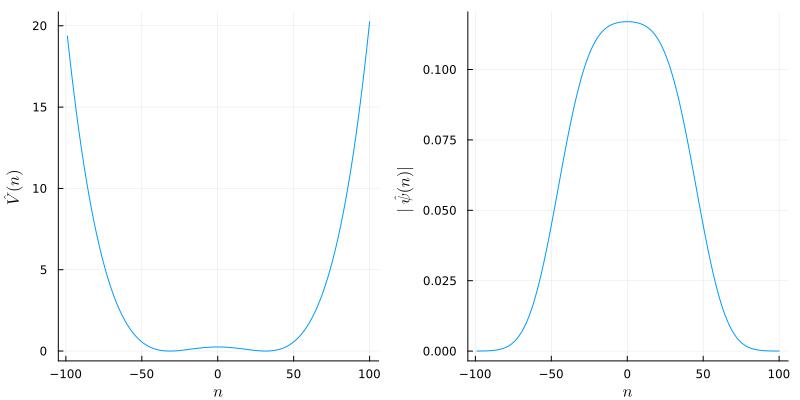

Half-space probability: 4.93182e-01

In [8]:
#Plot 1D potential & ground state

N = 200
μ, ϵ = 20, sqrt(0.001)
#cool plot: 51, 1, 0.07

n = lattice(N,1)
E_min, ψ_min = ground_state((N,), μ, ϵ, 1e-5, 10000, 1e-6, 1000)

#m = trunc(Int, N/2 + 1/ϵ)
#println("\n", (potential(μ,ϵ,n).*ψ_min)[m])

p_1 = plot(n, potential(μ, ϵ, n), label = nothing)
xlabel!(L"n"); ylabel!(L"\hat{V}\,(n)")
p_2 = plot(n, abs.(ψ_min), label = nothing)
xlabel!(L"n"); ylabel!(L"|\hat{\psi}\,(n)|")

p = plot(p_1, p_2, layout = (1,2), size = (800,400), left_margin = 3Plots.mm)
display(p)

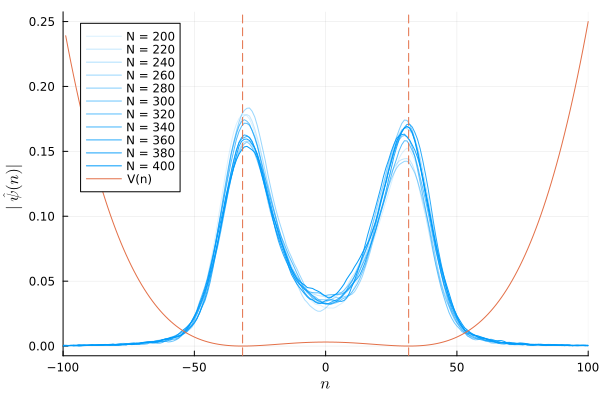

In [8]:
#Infinite-volume limit

N_0 = 200
ΔN, steps = 20, 10
μ, ϵ = 15, sqrt(0.001)

n = lattice(N_0, 1)
E_min, ψ_min = ground_state((N_0,), μ, ϵ, 1e-5, 10000, 1e-6, 1000; verbose = false)
p = plot(n, abs.(ψ_min), label = "N = $N_0", alpha = 0.15)
xlabel!(L"n"); ylabel!(L"|\hat{\psi}\,(n)|")
xlims!((-100,100))

for step in 1:steps
    N = N_0 + ΔN*step
    n = lattice(N,1)
    E_min, ψ_min = ground_state((N,), μ, ϵ, 1e-5, 10000, 1e-6, 1000; verbose = false)
    plot!(n, abs.(ψ_min), label = "N = $N", color = 1, alpha = 0.15 + 0.85*step/steps)
end

V = potential(μ, ϵ, lattice(N_0, 1))
plot!(lattice(N_0, 1), V/max(V...) * 0.25, color = 2, label = "V(n)")
vline!([1/ϵ, -1/ϵ], color = 2, label = nothing, linestyle = :dash)

display(p)

doesn't appear to converge, oscillates around maxima

ideas: stopping criterion for power method uses the Hamiltonian, where $\psi$ is multplied with the potential -> effect in the regions where $V\approx 0$ (around the minima at $n\approx\pm 1/\epsilon$)? Less noticeable for smaller $\mu$ since in that case, the kinetic term outweighs the potential term in the Hamiltonian and the wavefunction becomes less localized around the minima

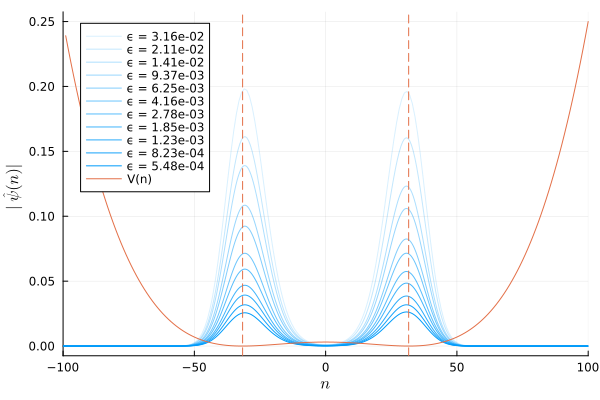

In [15]:
#Continuum limit

ϵ_0 = sqrt(0.001)
factor, steps = 2/3, 14
N_0, μ = 200, 20

n = lattice(N_0, 1)
E_min, ψ_min = ground_state((N_0,), μ, ϵ_0, 1e-4, 10000, 1e-5, 100000; verbose = false)
fmt = Printf.Format("ϵ = %.2e")
p = plot(n, abs.(ψ_min), label = Printf.format(fmt, ϵ_0), alpha = 0.15)
xlabel!(L"n"); ylabel!(L"|\hat{\psi}\,(n)|")
xlims!((-100,100))

for step in 1:steps
    ϵ = ϵ_0 * factor^step
    N = round(Int, N_0 / (factor^step)) #L ∝ ϵN held constant
    n = lattice(N,1) * N_0/N
    E_min, ψ_min = ground_state((N,), μ, ϵ, 1e-4, 10000, 1e-5, 100000; verbose = false)
    plot!(n, abs.(ψ_min), label = Printf.format(fmt, ϵ), color = 1, alpha = 0.15 + 0.85*step/steps)
end

V = potential(μ, ϵ_0, lattice(N_0, 1))
plot!(lattice(N_0, 1), V/max(V...) * 0.25, color = 2, label = "V(n)")
vline!([1/ϵ_0, -1/ϵ_0], color = 2, label = nothing, linestyle = :dash)

display(p)

seems to converge -> why not the same issue as above?

Energy: 4.78699e-01 ± 9.23131e-04
Position: (-5.17541e-02, 7.96966e-02) ± (2.17102e+01, 2.17661e+01)
Momentum: (1.16469e-04, 7.96957e-05) ± (6.71832e-02, 6.73514e-02)

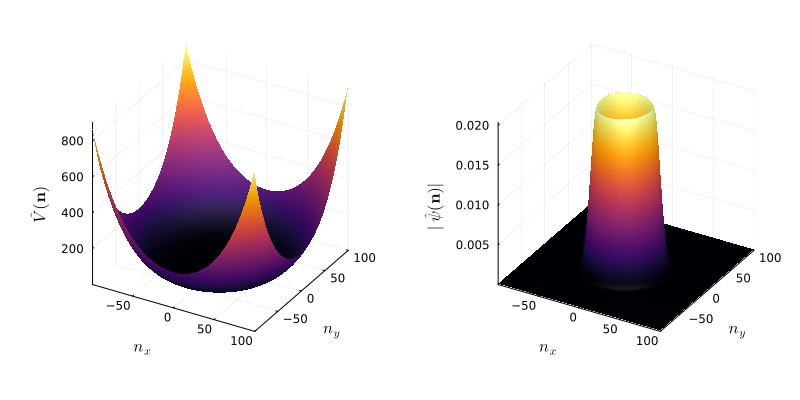


Half-space probability: 2.42899e-01

In [86]:
#Plot 2D potential & ground state

N = 200
μ, ϵ = 20, sqrt(0.001)
#cool plot: 21, 1, 0.12

n_1D = lattice(N, 1)
n = lattice(N, 2)
E_min, ψ_min = ground_state((N,N), μ, ϵ, 1e-4, 10000, 1e-5, 1000)
ψ_min = ψ_min/norm(ψ_min)

p_1 = surface(n_1D, n_1D, potential(μ, ϵ, n), legend = nothing)
xlabel!(L"n_x"); ylabel!(L"n_y"); zlabel!(L"\hat{V}\,(\textbf{n})")
p_2 = surface(n_1D, n_1D, abs.(ψ_min), legend = nothing)
xlabel!(L"n_x"); ylabel!(L"n_y"); zlabel!(L"|\hat{\psi}\,(\textbf{n})|")

p = plot(p_1, p_2, layout = (1,2), size = (800,400))
display(p)